## Problem Statement:
###         Predict the house prices for bangalore

## Import necessary libraries 

In [1]:
# Import numpy, pandas for data cleaning
import numpy as np
import pandas as pd

# Import seaborn and matplotlib for data visualization
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

# Setting defalt figure size 
#matplotlib.rcParams["figure.figsize"]=(20,10)

# Set max_rows and max_columsn while displaying a dataset
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Import linear regression model from sklearn for model building
from sklearn.linear_model import LinearRegression

# Import train_test_split module for creating train and test data set
from sklearn.model_selection import train_test_split


## 1. Data Gathering

### Read the data from CSV file 

In [2]:
df=pd.read_csv("Bengaluru_House_Data.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
# information about data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


## 2. Data Preprocssing 

### Basic Data Cleaning

In [5]:
# find the unique values for each feature
df.nunique()

area_type          4
availability      81
location        1305
size              31
society         2688
total_sqft      2117
bath              19
balcony            4
price           1994
dtype: int64

#### Identify and delete Columns That contains single unique value 

In [6]:
# Currently no features which has single unique value
print(df.nunique())

area_type          4
availability      81
location        1305
size              31
society         2688
total_sqft      2117
bath              19
balcony            4
price           1994
dtype: int64


Currently we don't have any features which has single unique value

#### Identify Columns That have very Few unique values

In [7]:
# area_type, balcony has only very very few unique values, bath, size and availability has few featues.

# get number of unique values for each column
counts = df.nunique()
# record columns to delete
to_del = [df.columns[i] for i,v in enumerate(counts) if (float(v)/df.shape[0]*100) < 1]
print(to_del)

['area_type', 'availability', 'size', 'bath', 'balcony']


Even though above columns has very few unique doesn't mean we need to remove them 

these values could be ordinal or categorical values.

lets examine further by checking unique values

In [8]:
for feature in to_del:
    print(feature, df[feature].unique()[:10])

area_type ['Super built-up  Area' 'Plot  Area' 'Built-up  Area' 'Carpet  Area']
availability ['19-Dec' 'Ready To Move' '18-May' '18-Feb' '18-Nov' '20-Dec' '17-Oct'
 '21-Dec' '19-Sep' '20-Sep']
size ['2 BHK' '4 Bedroom' '3 BHK' '4 BHK' '6 Bedroom' '3 Bedroom' '1 BHK'
 '1 RK' '1 Bedroom' '8 Bedroom']
bath [ 2.  5.  3.  4.  6.  1.  9. nan  8.  7.]
balcony [ 1.  3. nan  2.  0.]


In [9]:
# From above unique values we can conclude area_type and availability are Nominal variables has no relation ship between the values, so we can remove them 

print("Before :", df.shape)
df.drop(['area_type', 'availability'], axis=1, inplace=True)
print("After :", df.shape)

Before : (13320, 9)
After : (13320, 7)


#### Identify and delete the rows that contains duplicate data 

In [10]:
df.drop_duplicates(inplace=True)
df.shape

(12621, 7)

### Featue Imputation (Missing Values Treatment)

In [22]:
df.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [23]:
df.shape[0]

12548

In [13]:
## check the percentage of nan values present in each feature
## make the list of features which has missing values

def featuresWithNaN(df):
    features_with_nan=[feature for feature in df.columns if df[feature].isnull().sum()>=1]
    ## Mising percentage in each feature.
    for feature in features_with_nan:
        print(feature)
        print("    Missing Value Count      :", df[feature].isnull().sum())
        print("    Missing Value Percentage :", np.round(df[feature].isnull().mean(), 4))
        

featuresWithNaN(df)

location
    Missing Value Count      : 1
    Missing Value Percentage : 0.0001
size
    Missing Value Count      : 16
    Missing Value Percentage : 0.0013
society
    Missing Value Count      : 5299
    Missing Value Percentage : 0.4199
bath
    Missing Value Count      : 72
    Missing Value Percentage : 0.0057
balcony
    Missing Value Count      : 603
    Missing Value Percentage : 0.0478


####  There are many missing values, check the relation ship between missing values and dependent variable (price) 

<AxesSubplot:>

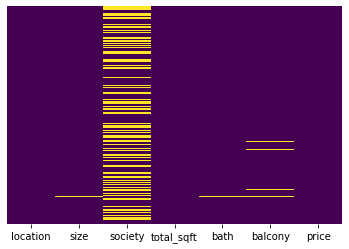

In [14]:
# Heat map will give high level idea of missing values in data frame
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

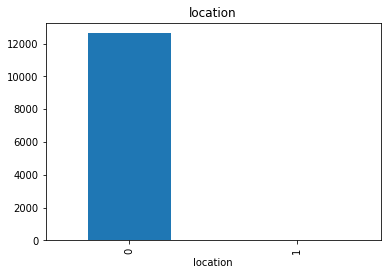

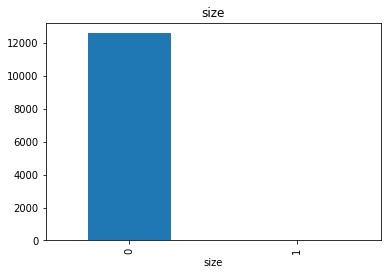

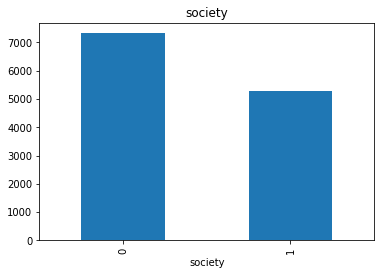

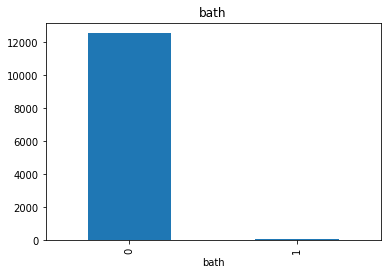

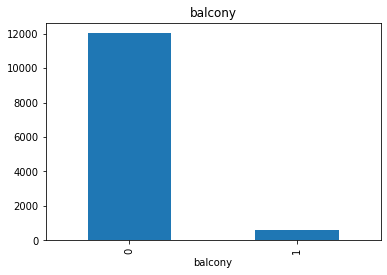

In [15]:
features_with_nan=[feature for feature in df.columns if df[feature].isnull().sum()>=1]
for feature in features_with_nan:
    df_nan = df.copy()
    
    #let's make a variable that indicates 1 if the observation was missing or zero otherwise
    df_nan[feature] = np.where(df_nan[feature].isnull(), 1, 0)
    
    # let's calculate the median price where the information is missing or present
    df_nan.groupby(feature)['price'].count().plot.bar()
    plt.title(feature)
    plt.show()

####  From above ploting we can clearly see "location, size, bath, balcony" has very few missing values and "society" has more missing values.
#### we assume "society" doesn't make much impact while diciding the price of a house, hence removing "society" feature from dataset

In [16]:
# Dropping "Society" feature from dataset
df.drop('society', axis=1, inplace=True)

In [17]:
featuresWithNaN(df)

location
    Missing Value Count      : 1
    Missing Value Percentage : 0.0001
size
    Missing Value Count      : 16
    Missing Value Percentage : 0.0013
bath
    Missing Value Count      : 72
    Missing Value Percentage : 0.0057
balcony
    Missing Value Count      : 603
    Missing Value Percentage : 0.0478


#### From above data, we assume "balcony" also has no impact while deciding the price of a house, hence removing "balcony" feature

In [18]:
# Dropping "balcony" feature.

df.drop('balcony', axis=1, inplace=True)

In [19]:
featuresWithNaN(df)

location
    Missing Value Count      : 1
    Missing Value Percentage : 0.0001
size
    Missing Value Count      : 16
    Missing Value Percentage : 0.0013
bath
    Missing Value Count      : 72
    Missing Value Percentage : 0.0057


#### Total number of missing values are very small so dropping all.

In [20]:
print("Shape Before ", df.shape)
df.dropna(axis=0, inplace=True)
print("Shape After ", df.shape)

Shape Before  (12621, 5)
Shape After  (12548, 5)


In [21]:
featuresWithNaN(df)

### Feature Encoding (Converting into numbers) 

In [24]:
def uniqueValuesinFeature(df):
    for feature in df.columns:
        print(feature, len(df[feature].unique()))
     
        
uniqueValuesinFeature(df)        

location 1304
size 31
total_sqft 2067
bath 19
price 1955


In [25]:
# Converting size variable into numbers
df['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [26]:
df['bhk']=df['size'].apply(lambda x:int(x.split(' ')[0]))

In [27]:
df.drop('size', axis=1, inplace=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12548 entries, 0 to 13318
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    12548 non-null  object 
 1   total_sqft  12548 non-null  object 
 2   bath        12548 non-null  float64
 3   price       12548 non-null  float64
 4   bhk         12548 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 588.2+ KB


In [29]:
df['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [30]:
# Convert total_sqft into number
df['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [31]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [32]:
df[~df['total_sqft'].apply(is_float)].head()

,location,total_sqft,bath,price,bhk
30,Yelahanka,2100 - 2850,4.0,186.000,4
122,Hebbal,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,1042 - 1105,2.0,54.005,2
165,Sarjapur,1145 - 1340,2.0,43.490,2
188,KR Puram,1015 - 1540,2.0,56.800,2


In [33]:
def convert_sqft_to_num(x):
    tokens=x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [34]:
convert_sqft_to_num('3000-4000')

3500.0

In [35]:
df['total_sqft']=df['total_sqft'].apply(convert_sqft_to_num)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12548 entries, 0 to 13318
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    12548 non-null  object 
 1   total_sqft  12502 non-null  float64
 2   bath        12548 non-null  float64
 3   price       12548 non-null  float64
 4   bhk         12548 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 588.2+ KB


#### Creating new feature "price_per_sqft" from exisitng features

In [37]:
df['price_per_sqft']= df['price']*100000/df['total_sqft']

In [38]:
df.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


In [39]:
# Analysing location feature.
len(df.location.unique())

1304

In [40]:
# Removing extra spaces around the data 
df.location=df.location.apply(lambda x:x.strip())

In [41]:
df.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


In [42]:
# understand more details about locations
# check how many data points per location
location_status = df.groupby('location')['location'].agg('count').sort_values(ascending=False)

In [43]:
# Checking data points per location is less than 10
len(location_status[location_status<=10])

1061

In [44]:
location_status_less_than_10 = location_status[location_status<=10]
location_status_less_than_10.count()

1061

In [45]:
df.location=df.location.apply(lambda x: 'other' if x in location_status_less_than_10 else x)
len(df.location.unique())

233

In [46]:
df.head(5)

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


### Removing Outliers 

In [47]:
df.shape

(12548, 6)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12548 entries, 0 to 13318
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   location        12548 non-null  object 
 1   total_sqft      12502 non-null  float64
 2   bath            12548 non-null  float64
 3   price           12548 non-null  float64
 4   bhk             12548 non-null  int64  
 5   price_per_sqft  12502 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 686.2+ KB


In [49]:
df.describe()

,total_sqft,bath,price,bhk,price_per_sqft
count,12502.000000,12548.000000,12548.000000,12548.000000,1.250200e+04
mean,1568.255472,2.713899,114.687807,2.821326,8.077096e+03
std,1265.167218,1.363452,152.372917,1.318354,1.096628e+05
min,1.000000,1.000000,8.000000,1.000000,2.678298e+02
25%,1100.000000,2.000000,50.000000,2.000000,4.300256e+03
50%,1280.000000,2.000000,73.000000,3.000000,5.490734e+03
75%,1690.000000,3.000000,122.000000,3.000000,7.425455e+03
max,52272.000000,40.000000,3600.000000,43.000000,1.200000e+07


In [50]:
# check if total_sqft/bhk is less than 300  
df[df.total_sqft/df.bhk<300].head()

,location,total_sqft,bath,price,bhk,price_per_sqft
9,other,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,1350.0,7.0,85.0,8,6296.296296
70,other,500.0,3.0,100.0,3,20000.000000


In [51]:
df.shape

(12548, 6)

In [52]:
# Removing outliers if total_sqft/bhk is less than 300
df=df[~(df.total_sqft/df.bhk<300)]
df.shape

(11816, 6)

In [53]:
# Removing price per sqft based on standard deviation, checking stadard deviation per lcoation
def remove_pps_outliers(df):
    df_out=pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m=np.mean(subdf.price_per_sqft)
        std=np.std(subdf.price_per_sqft)
        reduced_df=subdf[(subdf.price_per_sqft>(m-std)) & (subdf.price_per_sqft<=(m+std))]
        df_out=pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

In [54]:
df=remove_pps_outliers(df)
df.shape

(9695, 6)

<AxesSubplot:xlabel='price_per_sqft', ylabel='Count'>

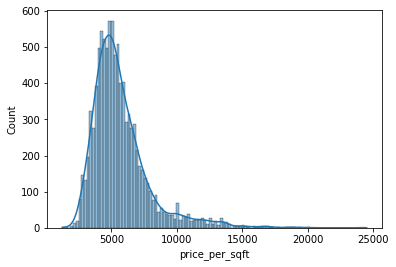

In [55]:
sns.histplot(df.price_per_sqft, kde=True)

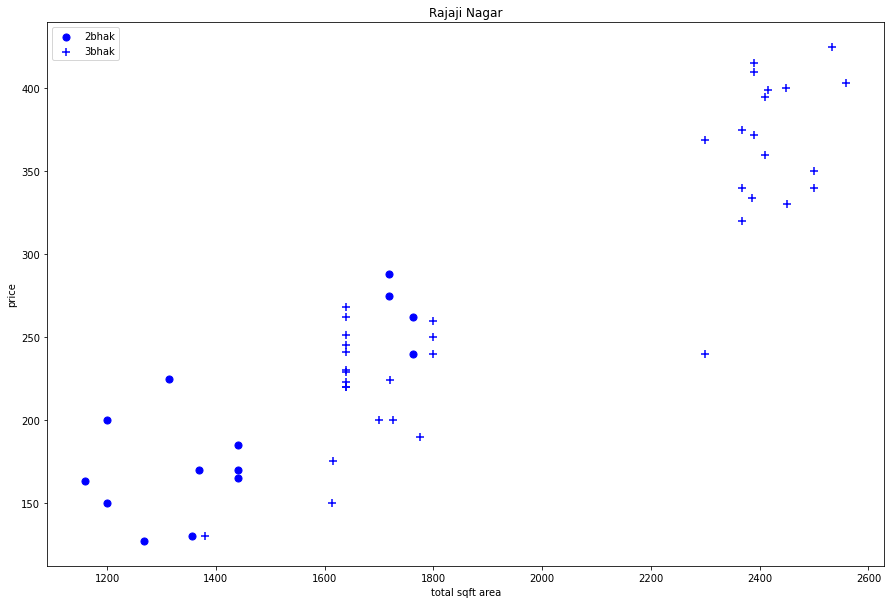

In [56]:
# Plot the data between price and total_sqft for 2bhk and 3bhk, see is there any outliers, 
# it means in same location price of 3bhk is less than 2 bhk
def plot_scatter_chart(df, location):
    bhk2=df[(df.location==location) & (df.bhk==2)]
    bhk3=df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize']=(15,10)
    plt.scatter(bhk2.total_sqft, bhk2.price, color='blue', label='2bhak', s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price, color='blue', label='3bhak', marker='+', s=50)
    plt.xlabel("total sqft area")
    plt.ylabel('price')
    plt.title(location)
    plt.legend()
plot_scatter_chart(df,"Rajaji Nagar")

In [57]:
def remove_bhk_outliers(df):
    exclude_indices=np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats={}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk]={
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df=remove_bhk_outliers(df)
df.shape

(6933, 6)

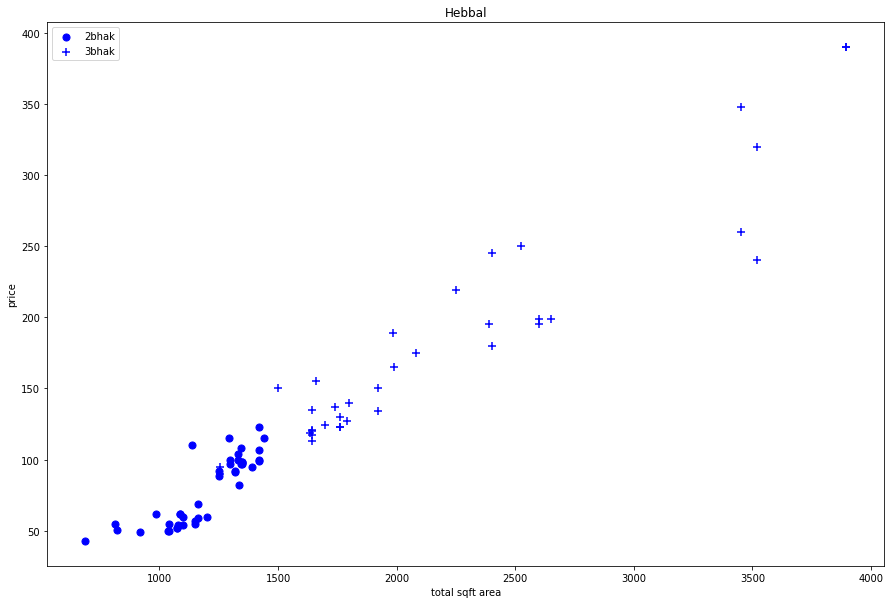

In [58]:
plot_scatter_chart(df,'Hebbal')

Text(0, 0.5, 'count')

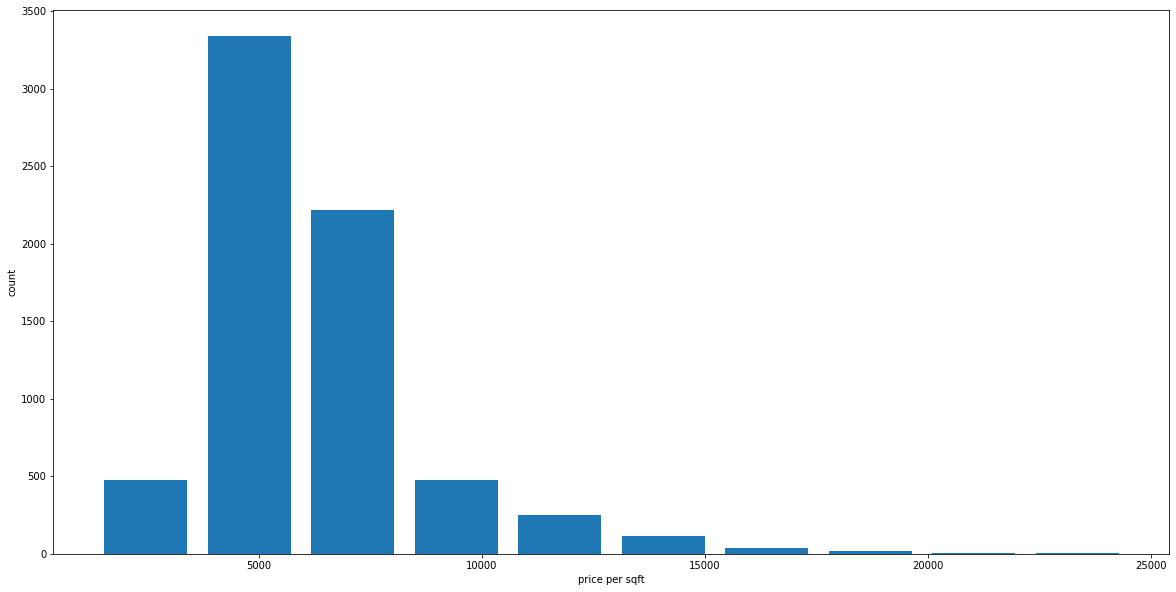

In [59]:
import matplotlib
matplotlib.rcParams['figure.figsize']=(20,10)
plt.hist(df.price_per_sqft, rwidth=0.8)
plt.xlabel('price per sqft')
plt.ylabel('count')

<AxesSubplot:xlabel='price_per_sqft', ylabel='Count'>

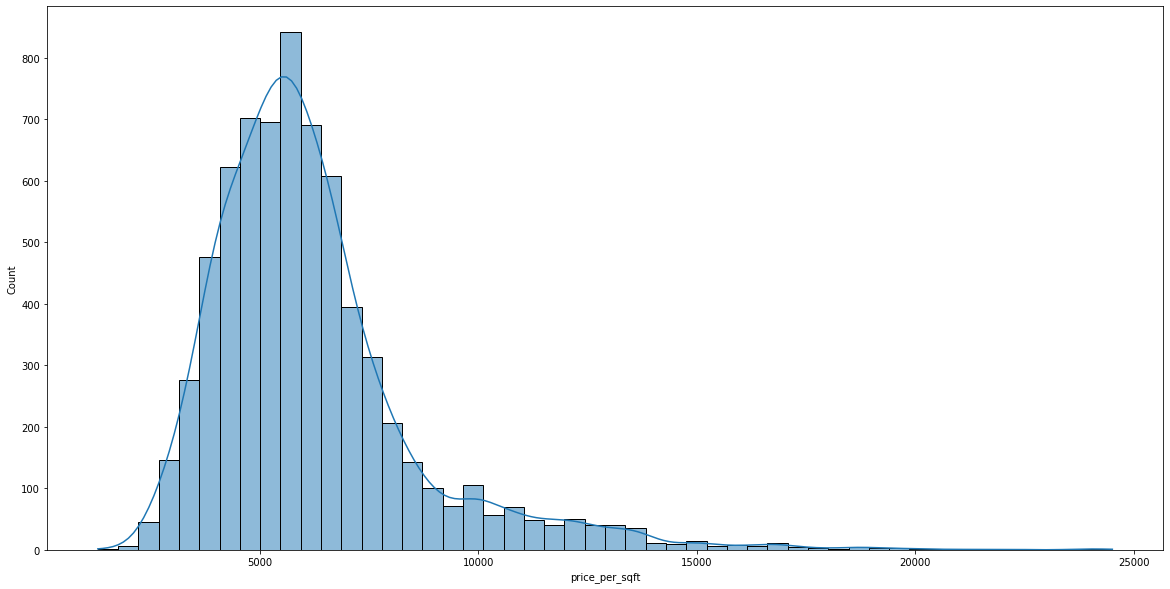

In [60]:
sns.histplot(data=df, x='price_per_sqft', bins=50, kde=True)

In [61]:
df.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [62]:
df[df.bath>10]

,location,total_sqft,bath,price,bhk,price_per_sqft
4882,Neeladri Nagar,4000.0,12.0,160.0,10,4000.000000
7920,other,12000.0,12.0,525.0,10,4375.000000
8014,other,10000.0,16.0,550.0,16,5500.000000
8756,other,6000.0,12.0,150.0,11,2500.000000
9096,other,5425.0,13.0,275.0,13,5069.124424


Text(0, 0.5, 'count')

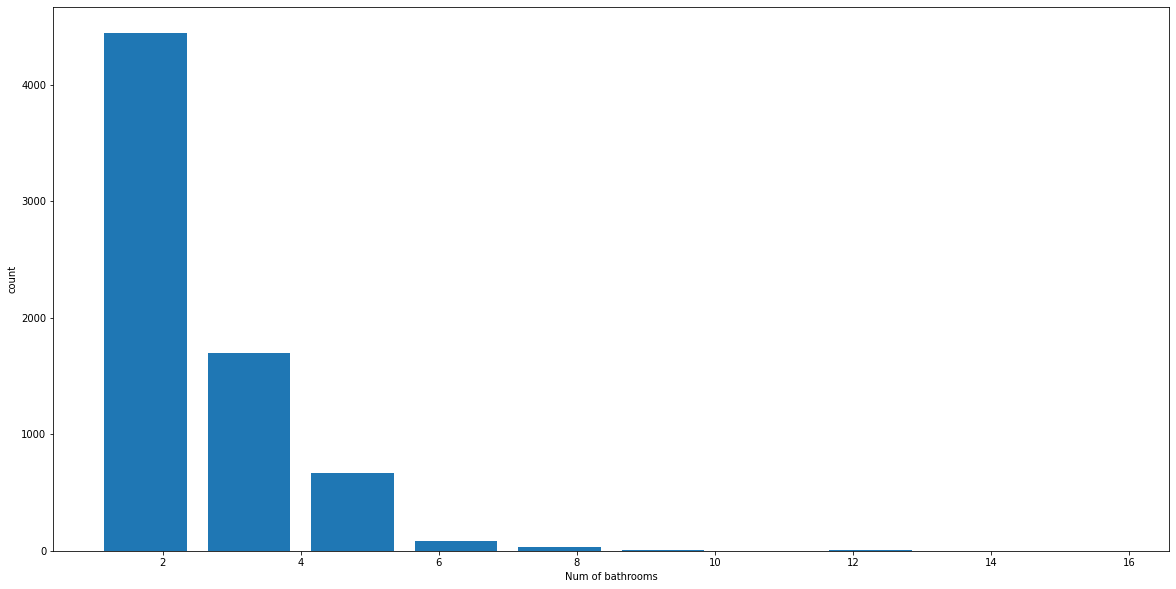

In [63]:
plt.hist(df.bath, rwidth=0.8)
plt.xlabel('Num of bathrooms')
plt.ylabel('count')

In [64]:
# Check the rows which has more bath rooms than bed rooms
df[df.bath>df.bhk+2]

,location,total_sqft,bath,price,bhk,price_per_sqft
1481,Chikkabanavar,2460.0,7.0,80.0,4,3252.032520
4851,Nagasandra,7000.0,8.0,450.0,4,6428.571429
6211,Thanisandra,1806.0,6.0,116.0,3,6423.034330
7843,other,11338.0,9.0,1000.0,6,8819.897689


In [65]:
print("Before :", df.shape)
df=df[df.bath<df.bhk+2]
print("After :", df.shape)

Before : (6933, 6)
After : (6852, 6)


In [66]:
# Dropping "price_per_sqft" feature because we can find price_per_sqft by using total_sqft and price features.
df.drop(['price_per_sqft'], axis=1, inplace=True)

In [67]:
df.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


#### Convert String values into Numerical values 

In [68]:
dummies=pd.get_dummies(df.location)
dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BTM 2nd Stage,BTM Layout,Babusapalaya,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,Banaswadi,Banjara Layout,Bannerghatta,Bannerghatta Road,Basavangudi,Basaveshwara Nagar,Battarahalli,Begur,Begur Road,Bellandur,Benson Town,Bharathi Nagar,Bhoganhalli,Billekahalli,Binny Pete,Bisuvanahalli,Bommanahalli,Bommasandra,Bommasandra Industrial Area,Bommenahalli,Brookefield,Budigere,CV Raman Nagar,Chamrajpet,Chandapura,Channasandra,Chikka Tirupathi,Chikkabanavar,Chikkalasandra,Choodasandra,Cooke Town,Cox Town,Cunningham Road,Dasanapura,Dasarahalli,Devanahalli,Devarachikkanahalli,Dodda Nekkundi,Doddaballapur,Doddakallasandra,Doddathoguru,Domlur,Dommasandra,EPIP Zone,Electronic City,Electronic City Phase II,Electronics City Phase 1,Frazer Town,GM Palaya,Garudachar Palya,Giri Nagar,Gollarapalya Hosahalli,Gottigere,Green Glen Layout,Gubbalala,Gunjur,HAL 2nd Stage,HBR Layout,HRBR Layout,HSR Layout,Haralur Road,Harlur,Hebbal,Hebbal Kempapura,Hegde Nagar,Hennur,Hennur Road,Hoodi,Horamavu Agara,Horamavu Banaswadi,Hormavu,Hosa Road,Hosakerehalli,Hoskote,Hosur Road,Hulimavu,ISRO Layout,Iblur Village,Indira Nagar,JP Nagar,Jakkur,Jalahalli,Jalahalli East,Jigani,Judicial Layout,KR Puram,Kadubeesanahalli,Kadugodi,Kaggadasapura,Kaggalipura,Kaikondrahalli,Kalena Agrahara,Kalyan nagar,Kambipura,Kammanahalli,Kammasandra,Kanakapura,Kanakpura Road,Kannamangala,Karuna Nagar,Kasavanhalli,Kasturi Nagar,Kathriguppe,Kaval Byrasandra,Kenchenahalli,Kengeri,Kengeri Satellite Town,Kereguddadahalli,Kodichikkanahalli,Kodigehaali,Kodigehalli,Kodihalli,Kogilu,Konanakunte,Koramangala,Kothannur,Kothanur,Kudlu,Kudlu Gate,Kumaraswami Layout,Kundalahalli,LB Shastri Nagar,Laggere,Lakshminarayana Pura,Lingadheeranahalli,Magadi Road,Mahadevpura,Mahalakshmi Layout,Mallasandra,Malleshpalya,Malleshwaram,Marathahalli,Margondanahalli,Mico Layout,Munnekollal,Murugeshpalya,Mysore Road,NGR Layout,NRI Layout,Nagarbhavi,Nagasandra,Nagavara,Nagavarapalya,Neeladri Nagar,Nehru Nagar,OMBR Layout,Old Airport Road,Old Madras Road,Padmanabhanagar,Pai Layout,Panathur,Poorna Pragna Layout,Prithvi Layout,R.T. Nagar,Rachenahalli,Raja Rajeshwari Nagar,Rajaji Nagar,Rajiv Nagar,Ramagondanahalli,Ramamurthy Nagar,Rayasandra,Sahakara Nagar,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Thyagaraja Nagar,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [69]:
df = pd.concat([df, dummies.drop(['other'], axis=1)], axis=1)
df.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BTM 2nd Stage,BTM Layout,Babusapalaya,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,Banaswadi,Banjara Layout,Bannerghatta,Bannerghatta Road,Basavangudi,Basaveshwara Nagar,Battarahalli,Begur,Begur Road,Bellandur,Benson Town,Bharathi Nagar,Bhoganhalli,Billekahalli,Binny Pete,Bisuvanahalli,Bommanahalli,Bommasandra,Bommasandra Industrial Area,Bommenahalli,Brookefield,Budigere,CV Raman Nagar,Chamrajpet,Chandapura,Channasandra,Chikka Tirupathi,Chikkabanavar,Chikkalasandra,Choodasandra,Cooke Town,Cox Town,Cunningham Road,Dasanapura,Dasarahalli,Devanahalli,Devarachikkanahalli,Dodda Nekkundi,Doddaballapur,Doddakallasandra,Doddathoguru,Domlur,Dommasandra,EPIP Zone,Electronic City,Electronic City Phase II,Electronics City Phase 1,Frazer Town,GM Palaya,Garudachar Palya,Giri Nagar,Gollarapalya Hosahalli,Gottigere,Green Glen Layout,Gubbalala,Gunjur,HAL 2nd Stage,HBR Layout,HRBR Layout,HSR Layout,Haralur Road,Harlur,Hebbal,Hebbal Kempapura,Hegde Nagar,Hennur,Hennur Road,Hoodi,Horamavu Agara,Horamavu Banaswadi,Hormavu,Hosa Road,Hosakerehalli,Hoskote,Hosur Road,Hulimavu,ISRO Layout,Iblur Village,Indira Nagar,JP Nagar,Jakkur,Jalahalli,Jalahalli East,Jigani,Judicial Layout,KR Puram,Kadubeesanahalli,Kadugodi,Kaggadasapura,Kaggalipura,Kaikondrahalli,Kalena Agrahara,Kalyan nagar,Kambipura,Kammanahalli,Kammasandra,Kanakapura,Kanakpura Road,Kannamangala,Karuna Nagar,Kasavanhalli,Kasturi Nagar,Kathriguppe,Kaval Byrasandra,Kenchenahalli,Kengeri,Kengeri Satellite Town,Kereguddadahalli,Kodichikkanahalli,Kodigehaali,Kodigehalli,Kodihalli,Kogilu,Konanakunte,Koramangala,Kothannur,Kothanur,Kudlu,Kudlu Gate,Kumaraswami Layout,Kundalahalli,LB Shastri Nagar,Laggere,Lakshminarayana Pura,Lingadheeranahalli,Magadi Road,Mahadevpura,Mahalakshmi Layout,Mallasandra,Malleshpalya,Malleshwaram,Marathahalli,Margondanahalli,Mico Layout,Munnekollal,Murugeshpalya,Mysore Road,NGR Layout,NRI Layout,Nagarbhavi,Nagasandra,Nagavara,Nagavarapalya,Neeladri Nagar,Nehru Nagar,OMBR Layout,Old Airport Road,Old Madras Road,Padmanabhanagar,Pai Layout,Panathur,Poorna Pragna Layout,Prithvi Layout,R.T. Nagar,Rachenahalli,Raja Rajeshwari Nagar,Rajaji Nagar,Rajiv Nagar,Ramagondanahalli,Ramamurthy Nagar,Rayasandra,Sahakara Nagar,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Thyagaraja Nagar,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [70]:
df.drop(['location'], axis=1, inplace= True)

In [71]:
df.head()

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BTM 2nd Stage,BTM Layout,Babusapalaya,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,Banaswadi,Banjara Layout,Bannerghatta,Bannerghatta Road,Basavangudi,Basaveshwara Nagar,Battarahalli,Begur,Begur Road,Bellandur,Benson Town,Bharathi Nagar,Bhoganhalli,Billekahalli,Binny Pete,Bisuvanahalli,Bommanahalli,Bommasandra,Bommasandra Industrial Area,Bommenahalli,Brookefield,Budigere,CV Raman Nagar,Chamrajpet,Chandapura,Channasandra,Chikka Tirupathi,Chikkabanavar,Chikkalasandra,Choodasandra,Cooke Town,Cox Town,Cunningham Road,Dasanapura,Dasarahalli,Devanahalli,Devarachikkanahalli,Dodda Nekkundi,Doddaballapur,Doddakallasandra,Doddathoguru,Domlur,Dommasandra,EPIP Zone,Electronic City,Electronic City Phase II,Electronics City Phase 1,Frazer Town,GM Palaya,Garudachar Palya,Giri Nagar,Gollarapalya Hosahalli,Gottigere,Green Glen Layout,Gubbalala,Gunjur,HAL 2nd Stage,HBR Layout,HRBR Layout,HSR Layout,Haralur Road,Harlur,Hebbal,Hebbal Kempapura,Hegde Nagar,Hennur,Hennur Road,Hoodi,Horamavu Agara,Horamavu Banaswadi,Hormavu,Hosa Road,Hosakerehalli,Hoskote,Hosur Road,Hulimavu,ISRO Layout,Iblur Village,Indira Nagar,JP Nagar,Jakkur,Jalahalli,Jalahalli East,Jigani,Judicial Layout,KR Puram,Kadubeesanahalli,Kadugodi,Kaggadasapura,Kaggalipura,Kaikondrahalli,Kalena Agrahara,Kalyan nagar,Kambipura,Kammanahalli,Kammasandra,Kanakapura,Kanakpura Road,Kannamangala,Karuna Nagar,Kasavanhalli,Kasturi Nagar,Kathriguppe,Kaval Byrasandra,Kenchenahalli,Kengeri,Kengeri Satellite Town,Kereguddadahalli,Kodichikkanahalli,Kodigehaali,Kodigehalli,Kodihalli,Kogilu,Konanakunte,Koramangala,Kothannur,Kothanur,Kudlu,Kudlu Gate,Kumaraswami Layout,Kundalahalli,LB Shastri Nagar,Laggere,Lakshminarayana Pura,Lingadheeranahalli,Magadi Road,Mahadevpura,Mahalakshmi Layout,Mallasandra,Malleshpalya,Malleshwaram,Marathahalli,Margondanahalli,Mico Layout,Munnekollal,Murugeshpalya,Mysore Road,NGR Layout,NRI Layout,Nagarbhavi,Nagasandra,Nagavara,Nagavarapalya,Neeladri Nagar,Nehru Nagar,OMBR Layout,Old Airport Road,Old Madras Road,Padmanabhanagar,Pai Layout,Panathur,Poorna Pragna Layout,Prithvi Layout,R.T. Nagar,Rachenahalli,Raja Rajeshwari Nagar,Rajaji Nagar,Rajiv Nagar,Ramagondanahalli,Ramamurthy Nagar,Rayasandra,Sahakara Nagar,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Thyagaraja Nagar,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [72]:
df.describe()

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BTM 2nd Stage,BTM Layout,Babusapalaya,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,Banaswadi,Banjara Layout,Bannerghatta,Bannerghatta Road,Basavangudi,Basaveshwara Nagar,Battarahalli,Begur,Begur Road,Bellandur,Benson Town,Bharathi Nagar,Bhoganhalli,Billekahalli,Binny Pete,Bisuvanahalli,Bommanahalli,Bommasandra,Bommasandra Industrial Area,Bommenahalli,Brookefield,Budigere,CV Raman Nagar,Chamrajpet,Chandapura,Channasandra,Chikka Tirupathi,Chikkabanavar,Chikkalasandra,Choodasandra,Cooke Town,Cox Town,Cunningham Road,Dasanapura,Dasarahalli,Devanahalli,Devarachikkanahalli,Dodda Nekkundi,Doddaballapur,Doddakallasandra,Doddathoguru,Domlur,Dommasandra,EPIP Zone,Electronic City,Electronic City Phase II,Electronics City Phase 1,Frazer Town,GM Palaya,Garudachar Palya,Giri Nagar,Gollarapalya Hosahalli,Gottigere,Green Glen Layout,Gubbalala,Gunjur,HAL 2nd Stage,HBR Layout,HRBR Layout,HSR Layout,Haralur Road,Harlur,Hebbal,Hebbal Kempapura,Hegde Nagar,Hennur,Hennur Road,Hoodi,Horamavu Agara,Horamavu Banaswadi,Hormavu,Hosa Road,Hosakerehalli,Hoskote,Hosur Road,Hulimavu,ISRO Layout,Iblur Village,Indira Nagar,JP Nagar,Jakkur,Jalahalli,Jalahalli East,Jigani,Judicial Layout,KR Puram,Kadubeesanahalli,Kadugodi,Kaggadasapura,Kaggalipura,Kaikondrahalli,Kalena Agrahara,Kalyan nagar,Kambipura,Kammanahalli,Kammasandra,Kanakapura,Kanakpura Road,Kannamangala,Karuna Nagar,Kasavanhalli,Kasturi Nagar,Kathriguppe,Kaval Byrasandra,Kenchenahalli,Kengeri,Kengeri Satellite Town,Kereguddadahalli,Kodichikkanahalli,Kodigehaali,Kodigehalli,Kodihalli,Kogilu,Konanakunte,Koramangala,Kothannur,Kothanur,Kudlu,Kudlu Gate,Kumaraswami Layout,Kundalahalli,LB Shastri Nagar,Laggere,Lakshminarayana Pura,Lingadheeranahalli,Magadi Road,Mahadevpura,Mahalakshmi Layout,Mallasandra,Malleshpalya,Malleshwaram,Marathahalli,Margondanahalli,Mico Layout,Munnekollal,Murugeshpalya,Mysore Road,NGR Layout,NRI Layout,Nagarbhavi,Nagasandra,Nagavara,Nagavarapalya,Neeladri Nagar,Nehru Nagar,OMBR Layout,Old Airport Road,Old Madras Road,Padmanabhanagar,Pai Layout,Panathur,Poorna Pragna Layout,Prithvi Layout,R.T. Nagar,Rachenahalli,Raja Rajeshwari Nagar,Rajaji Nagar,Rajiv Nagar,Ramagondanahalli,Ramamurthy Nagar,Rayasandra,Sahakara Nagar,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Thyagaraja Nagar,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
count,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6852.000000,6

In [73]:
df.columns

Index(['total_sqft', 'bath', 'price', 'bhk', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Stage Nagarbhavi', '5th Block Hbr Layout',
       '5th Phase JP Nagar', '6th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=236)

In [74]:
featuresWithNaN(df)

In [75]:
# Standard Scaller

feature_scale = ['total_sqft','bath','bhk']

from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
scaled = scaler.fit_transform(df[feature_scale])
df_scaled=pd.DataFrame(scaled, columns=feature_scale)
df_scaled.head()

,total_sqft,bath,bhk
0,1.638671,1.651031,1.623522
1,0.175401,0.602087,0.541911
2,0.469254,-0.446858,0.541911
3,-0.340342,-0.446858,0.541911
4,-0.298363,-0.446858,-0.539701


In [76]:
df_scaled.describe()

,total_sqft,bath,bhk
count,6.852000e+03,6.852000e+03,6.852000e+03
mean,-4.977532e-17,-1.078465e-16,-1.161424e-16
std,1.000073e+00,1.000073e+00,1.000073e+00
min,-1.419803e+00,-1.495802e+00,-1.621312e+00
25%,-4.689778e-01,-4.468575e-01,-5.397008e-01
50%,-2.659791e-01,-4.468575e-01,-5.397008e-01
75%,2.284742e-01,6.020865e-01,5.419108e-01
max,3.420242e+01,1.423836e+01,1.460286e+01


In [79]:
print(df.shape, df_scaled.shape)

(6852, 236) (6852, 3)


In [94]:
df=df.drop(feature_scale, axis=1)
df=pd.concat([df.reset_index(drop=True), df_scaled], axis = 1)
df.shape

(6852, 236)

In [95]:
featuresWithNaN(df)

### Create Train Test data 

In [96]:
X=df.drop(['price'], axis=1)
y=df.price

In [97]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=10)

In [98]:
len(X_train), len(X_test)

(5481, 1371)

### Select a model and Train it

In [99]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_test, y_test)

0.8172768720085892

In [102]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
cv=ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.79194216, 0.87085899, 0.80718565, 0.8141385 , 0.83680941])

#### Using GridSearchCV find the best model 

In [108]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
               
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['squared_error','friedman_mse'],
                'splitter': ['best','random']
            }
        },
        'svr': {
            'model': SVR(),
            'params': {
                
            }
        },
        'ridge': {
            'model': Ridge(),
            'params': {
                
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.824187,{}
1,lasso,0.683923,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.658304,"{'criterion': 'squared_error', 'splitter': 'ra..."
3,svr,0.458544,{}
4,ridge,0.821443,{}


In [109]:
X.columns

Index(['1st Block Jayanagar', '1st Phase JP Nagar', '2nd Stage Nagarbhavi',
       '5th Block Hbr Layout', '5th Phase JP Nagar', '6th Phase JP Nagar',
       '7th Phase JP Nagar', '8th Phase JP Nagar', '9th Phase JP Nagar',
       'AECS Layout',
       ...
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur', 'total_sqft',
       'bath', 'bhk'],
      dtype='object', length=235)

In [110]:
def predict_price(location, sqft='', bhk='', bath=''):    
    loc_index=np.where(X.columns==location)[0][0]
    x_vals=np.zeros(len(X.columns))
    x_vals[0]=sqft
    x_vals[1]=bhk
    x_vals[2]=bath
    if loc_index >=0:
        x_vals[loc_index]=1
    return lr.predict([x_vals])[0]

In [111]:
predict_price('Indira Nagar', 1000, 3, 3)

C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


124004.27455293405

In [112]:
import pickle
with open('bangalore_home_price_model.pickle','wb') as f:
    pickle.dump(lr, f)

In [113]:
import json
columns ={
        'data_columns':[col.lower() for col in X.columns] 
}
with open('columns.json','w') as f:
    f.write(json.dumps(columns))